In [7]:
import sys
sys.path.append('../')
import torch
import itertools
from probe.load_data import WordInspectionDataset, SentenceParaphraseInspectionDataset
from scipy.spatial.distance import cosine
from statistics import mean 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import argparse
import time

In [2]:
words, paraphrase_sent_pairs = 'words', 'para_pairs'

def main(input_args):
    if input_args.comparison_type == words:
        word_usage_comparisons(input_args)
    else:
        sentence_paraphrase_comparisons(input_args)


def sentence_paraphrase_comparisons(input_args):
    dataset = SentenceParaphraseInspectionDataset(input_args.input, input_args.embedding_model, 
                                                input_args.embedding_batch_size, input_args.run_name)

    embeddings = get_embeddings(dataset, input_args.embedding_cache, flattened=True)
    embedding_outputs, encoded_inputs, indices = embeddings
    sentence_embeddings = get_sentence_embeddings(embeddings, dataset)

    paraphrase_cosine_metrics = calculate_sentence_paraphrase_cosine_metrics(dataset, embedding_outputs, 
                                                                            encoded_inputs, sentence_embeddings)
    
    print(paraphrase_cosine_metrics)
    print(summarize_sentence_similarity_comp(paraphrase_cosine_metrics))


def word_usage_comparisons(input_args):
    dataset = WordInspectionDataset(input_args.input, input_args.embedding_model, 
                                    input_args.embedding_batch_size, input_args.run_name)
    embeddings = get_embeddings(dataset, input_args.embedding_cache, flattened=False)
    embedding_outputs, encoded_inputs, _indices = embeddings
    data = dataset.get_data()
    idiom_sentence_indexes = get_idiom_sentences(data)

    word_sim_results = calculate_word_cosine_metrics(dataset, embedding_outputs, encoded_inputs, idiom_sentence_indexes)
    print(word_sim_results)
    print(summarize_word_similarity_comp(word_sim_results))

    PCA_comparisions(dataset, embedding_outputs, encoded_inputs, idiom_sentence_indexes)


def get_embeddings(data, embedding_cache, flattened):
    if embedding_cache is None:
        if flattened:
            encoded_data = data.get_flattened_encoded()
        else:
            encoded_data = data.get_encoded()
        return data.bert_word_embeddings(encoded_data)
    return data.load_saved_embeddings(embedding_cache)

def get_sentence_embeddings(embeddings, data):
    embedding_outputs, encoded_inputs, indices = embeddings
    return data.aggregate_sentence_embeddings(embedding_outputs, encoded_inputs, indices)

def calculate_sentence_paraphrase_cosine_metrics(dataset, embedding_outputs, encoded_inputs, sentence_embeddings):
    data = dataset.get_data()
    paraphrase_cosine_metrics = [calculate_paraphrase_pair_similarity(i, pair_sents, dataset, encoded_inputs, sentence_embeddings) 
                            for i, pair_sents in enumerate(data)]
    return paraphrase_cosine_metrics

def calculate_word_cosine_metrics(dataset, embedding_outputs, encoded_inputs, idiom_sentence_indexes):
    word_cosine_metrics = [calculate_word_similarity_metrics(idiom_sent_idx, dataset, embedding_outputs, encoded_inputs) 
                            for idiom_sent_idx in idiom_sentence_indexes]
    return word_cosine_metrics

def calculate_paraphrase_pair_similarity(index, classifier_out, dataset, encoded_inputs, sentence_embeddings):
    cosine_sim = 1 - cosine(sentence_embeddings[index][0], sentence_embeddings[index][1])
    
    return {
        'pair_index': index,
        'sent_1': dataset.decode(encoded_inputs[index][0].tolist()),
        'sent_2': dataset.decode(encoded_inputs[index][1].tolist()),
        'paraphrase': classifier_out.label,
        'judgment': classifier_out.classifier_judgment,
        'cosine_similarity': cosine_sim
    }    

def calculate_word_similarity_metrics(idiom_sent_index, dataset, embedding_outputs, encoded_inputs):
    data = dataset.get_data()
    idiom_ex = data[idiom_sent_index]
    idiom_word_embedding = get_word_embedding(dataset, data, embedding_outputs, encoded_inputs, idiom_sent_index)
    cosine_similarity_metrics = {}

    literal_usage_sents = [i for i, ex in enumerate(data) if ex.pair_id == idiom_ex.pair_id and 
                                                            ex.word == idiom_ex.word and not 
                                                            ex.sentence_id == idiom_ex.sentence_id ]
    paraphrase_sents = [i for i, ex in enumerate(data) if ex.pair_id == idiom_ex.pair_id 
                                                            and not ex.word == idiom_ex.word]

    literal_usage_embeddings = [get_word_embedding(dataset, data, embedding_outputs, encoded_inputs, lit_idx) for lit_idx in literal_usage_sents]
    paraphrase_embeddings = [get_word_embedding(dataset, data, embedding_outputs, encoded_inputs, para_idx) for para_idx in paraphrase_sents]

    cosine_similarity_metrics['fig_to_literal'] = calculate_cosine_similarity_average([idiom_word_embedding], literal_usage_embeddings)
    cosine_similarity_metrics['literal_to_literal'] = calculate_cosine_similarity_average(literal_usage_embeddings)
    cosine_similarity_metrics['fig_to_paraphrase'] = calculate_cosine_similarity_average([idiom_word_embedding], paraphrase_embeddings)
    cosine_similarity_metrics['literal_to_paraphrase'] = calculate_cosine_similarity_average(literal_usage_embeddings, paraphrase_embeddings)
    
    return {
        'sentence_id': idiom_ex.sentence_id,
        'sentence': dataset.decode(encoded_inputs[idiom_sent_index].tolist()),
        'word': idiom_ex.word,
        'paraphrase_word': data[paraphrase_sents[0]].word,
        'cosine_similarities': cosine_similarity_metrics,
    }

def get_idiom_sentences(dataset):
    return [i for i, ex in enumerate(dataset) if ex.figurative]

def get_sentences_for_idiom_sentence(dataset, idiom_sent):
    literal_usage_sents = [i for i, ex in enumerate(dataset) if ex.pair_id == idiom_sent.pair_id and 
                                                                ex.word == idiom_sent.word and not 
                                                                ex.sentence_id == idiom_sent.sentence_id ]
    paraphrase_sents = [i for i, ex in enumerate(dataset) if ex.pair_id == idiom_sent.pair_id and not 
                                                            ex.word == idiom_sent.word]
    return (literal_usage_sents, paraphrase_sents)

def get_word_embedding(dataset, data, embedding_outputs, encoded_inputs, dataset_index):
    ex = data[dataset_index]
    decoded_tokens = dataset.get_decoded_tokens(encoded_inputs[dataset_index].tolist())
    word_index = decoded_tokens.index(ex.word[0])
    return embedding_outputs[dataset_index][word_index]

def calculate_cosine_similarity_average(embeddings_1, embeddings_2=None):
    if embeddings_2:
        embedding_pairs = list(itertools.product(embeddings_1, embeddings_2))
    else:
        embedding_pairs = list(itertools.combinations(embeddings_1, 2))

    cosine_similarities = [1 - cosine(embedding_1, embedding_2) for embedding_1, embedding_2 in embedding_pairs]
    return mean(cosine_similarities)

# This computes the average difference in cosine similarity between:
# 1.) literal to literal usages versus figurative to literal usage
# 2.) figurative to paraphrase usages versus literal to paraphrase useage
def summarize_word_similarity_comp(results):
    literal_sim_advantage = [result['cosine_similarities']['literal_to_literal'] - result['cosine_similarities']['fig_to_literal'] for result in results]
    fig_to_paraphrase_advantage = [result['cosine_similarities']['fig_to_paraphrase'] - result['cosine_similarities']['literal_to_paraphrase'] for result in results]
    
    summary_stats = {
        'lit_to_lit_improvement_over_fig_to_lit': mean(literal_sim_advantage),
        'fig_to_paraphrase_improvement_over_lit_to_paraphrase': mean(fig_to_paraphrase_advantage)
    }
    return summary_stats

# This computes the average cosine similarity scores between paraphrase pairs,
# grouped into 4 categories based on gold label (i.e. true paraphrase or not) and classifier judgment
def summarize_sentence_similarity_comp(results):
    correctly_judged_paraphrases = [result['cosine_similarity'] for result in results if result['paraphrase'] and result['judgment']]
    correctly_judged_non_paraphrases = [result['cosine_similarity'] for result in results if not result['paraphrase'] and not result['judgment']]
    incorrectly_judged_paraphrases =  [result['cosine_similarity'] for result in results if result['paraphrase'] and not result['judgment']]
    incorrectly_judged_non_paraphrases =  [result['cosine_similarity'] for result in results if not result['paraphrase'] and result['judgment']]

    return {
        'average_cosine_sim_for_correctly_judged_paraphrases': handle_zero_case(correctly_judged_paraphrases),
        'average_cosine_sim_for_correctly_judged_non_paraphrases': handle_zero_case(correctly_judged_non_paraphrases),
        'average_cosine_sim_for_incorrectly_judged_paraphrases': handle_zero_case(incorrectly_judged_paraphrases),
        'average_cosine_sim_for_incorrectly_judged_non_paraphrases': handle_zero_case(incorrectly_judged_non_paraphrases)
    }

def handle_zero_case(category_results):
    if not category_results:
        return 'N/A'
    return mean(category_results)


# PCA visualization code
# TODO: figure out what we actually want to include/disclude here and clean up

def PCA_comparisions(dataset, embedding_outputs, encoded_inputs, idiom_sentence_indexes):
    data = dataset.get_data()
    for idiom_sent_index in idiom_sentence_indexes:
        idiom_ex = data[idiom_sent_index]
        idiom_word_embedding = get_word_embedding(dataset, data, embedding_outputs, encoded_inputs, idiom_sent_index)
        literal_usage_sents = [i for i, ex in enumerate(data) if ex.pair_id == idiom_ex.pair_id and 
                                                                ex.word == idiom_ex.word and not 
                                                                ex.sentence_id == idiom_ex.sentence_id ]
        paraphrase_sents = [i for i, ex in enumerate(data) if ex.pair_id == idiom_ex.pair_id 
                                                                and not ex.word == idiom_ex.word]

        literal_usage_embeddings = [get_word_embedding(dataset, data, embedding_outputs, encoded_inputs, lit_idx) for lit_idx in literal_usage_sents]
        paraphrase_embeddings = [get_word_embedding(dataset, data, embedding_outputs, encoded_inputs, para_idx) for para_idx in paraphrase_sents]

        title = 'PCA for {}: Fig usage {} Paraphrase word: {}'.format(idiom_ex.word[0], " ".join(idiom_ex.sentence), data[paraphrase_sents[0]].word)
        targets = {
            'labels': ['figurative', 'literal'],
            'values': [0, 1] ,
            'colors': ['turquoise', 'navy'],
        }
        labels =  np.array(len(literal_usage_embeddings) * [1] + [0])
        show_PCS(literal_usage_embeddings + [idiom_word_embedding], labels, targets, title)

        title = 'PCA for {}: Fig usage {}'.format(idiom_ex.word[0], " ".join(idiom_ex.sentence))
        targets = {
            'labels': ['figurative', 'literal', 'paraphrase'],
            'values': [0, 1, 2] ,
            'colors': ['turquoise', 'navy', 'orangered'],
        }
        embeddings = literal_usage_embeddings + [idiom_word_embedding] + paraphrase_embeddings
        labels =  np.array(len(literal_usage_embeddings) * [1] + [0] + len(paraphrase_embeddings) * [2])
        show_PCS(embeddings, labels, targets, title)

def show_PCS(embeddings, labels, targets, title):
    pca = PCA(2)  
    projected = pca.fit_transform(torch.stack(embeddings))

    for color, i, target_name in zip(targets['colors'], targets['values'], targets['labels']):
        plt.scatter(projected[labels == i, 0], projected[labels == i, 1], color=color,  lw=2,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title)
    plt.show()


In [3]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-large-uncased-vocab.txt HTTP/1.1" 200 0
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt from cache at /Users/paigefink/.cache/torch/transformers/9b3c03a36e83b13d5ba95ac965c9f9074a99e14340c523ab405703179e79fc46.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:data_loading:Loading 'bert-large-uncased' model
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-large-uncased-config.json HTTP/1.1" 200 0
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json from cache at /Users/paigefink/.cac

INFO:data_loading:processed 16/60 sentences, current max sentence length 21
INFO:data_loading:processed 32/60 sentences, current max sentence length 21
INFO:data_loading:processed 48/60 sentences, current max sentence length 22
INFO:data_loading:processed 60/60 sentences, current max sentence length 22
INFO:data_loading:Caching info for this run in cache/word_large_test
INFO:data_loading:Please pass this folder in to future invocations to use cached data
INFO:data_loading:Caching sentences.pt in cache/word_large_test
INFO:data_loading:Caching inputs.pt in cache/word_large_test


INFO:data_loading:Caching indices.pt in cache/word_large_test


[{'sentence_id': 1, 'sentence': '[CLS] the cat is out of the bag. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'word': ['cat'], 'paraphrase_word': ['secret'], 'cosine_similarities': {'fig_to_literal': 0.8095400002267625, 'literal_to_literal': 0.881085894174046, 'fig_to_paraphrase': 0.5299287855625152, 'literal_to_paraphrase': 0.5367808659871419}}, {'sentence_id': 21, 'sentence': "[CLS] soon we're going to hit the sack. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]", 'word': ['sack'], 'paraphrase_word': ['bed'], 'cosine_similarities': {'fig_to_literal': 0.5062072972456614, 'literal_to_literal': 0.7760081390539805, 'fig_to_paraphrase': 0.4422173142433167, 'literal_to_paraphrase': 0.4630802823437585}}, {'sentence_id': 41, 'sentence': '[CLS] it is time to bite the bullet. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'word': ['bullet'], 'paraphrase_word': ['situation'], 'cosine_similarities': {'fig_to_

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


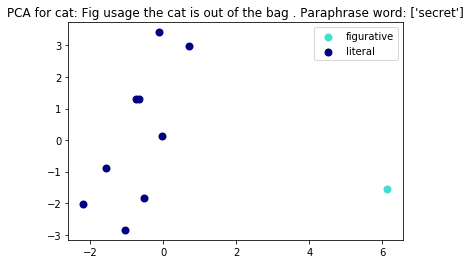

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


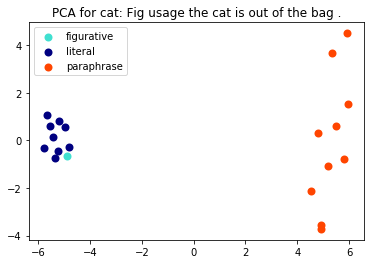

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


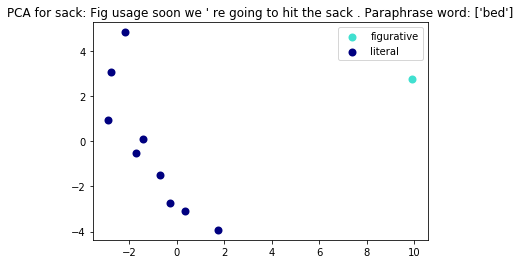

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


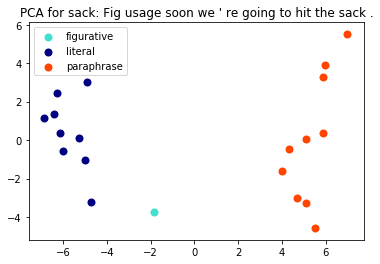

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


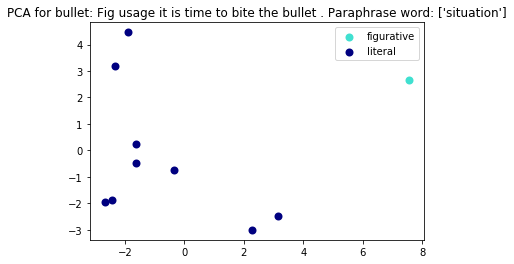

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


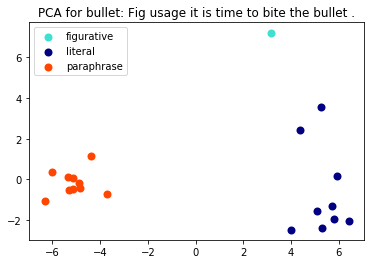

In [4]:
# BERT - LARGE

word_args = {
   'comparison_type': 'words',
    'input': 'word_vec_sim_test.txt',
    'embedding_model': 'bert-large-uncased',
    'run_name': 'word_large_test',
    'embedding_batch_size': 16,
    'embedding_cache': None
}

main(objectview(word_args))

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-base-uncased-vocab.txt HTTP/1.1" 200 0
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /Users/paigefink/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:data_loading:Loading 'bert-base-uncased' model
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-base-uncased-config.json HTTP/1.1" 200 0
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /Users/paigefink/.cache/to

INFO:data_loading:processed 16/60 sentences, current max sentence length 21
INFO:data_loading:processed 32/60 sentences, current max sentence length 21
INFO:data_loading:processed 48/60 sentences, current max sentence length 22
INFO:data_loading:processed 60/60 sentences, current max sentence length 22
INFO:data_loading:Caching info for this run in cache/word_base_test
INFO:data_loading:Please pass this folder in to future invocations to use cached data
INFO:data_loading:Caching sentences.pt in cache/word_base_test
INFO:data_loading:Caching inputs.pt in cache/word_base_test


INFO:data_loading:Caching indices.pt in cache/word_base_test


[{'sentence_id': 1, 'sentence': '[CLS] the cat is out of the bag. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'word': ['cat'], 'paraphrase_word': ['secret'], 'cosine_similarities': {'fig_to_literal': 0.7656194236543443, 'literal_to_literal': 0.7806152949730555, 'fig_to_paraphrase': 0.3347825944423676, 'literal_to_paraphrase': 0.30739231490426594}}, {'sentence_id': 21, 'sentence': "[CLS] soon we're going to hit the sack. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]", 'word': ['sack'], 'paraphrase_word': ['bed'], 'cosine_similarities': {'fig_to_literal': 0.4551817211839888, 'literal_to_literal': 0.6645340853267245, 'fig_to_paraphrase': 0.2750953704118729, 'literal_to_paraphrase': 0.33391864813036387}}, {'sentence_id': 41, 'sentence': '[CLS] it is time to bite the bullet. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'word': ['bullet'], 'paraphrase_word': ['situation'], 'cosine_similarities': {'fig_

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


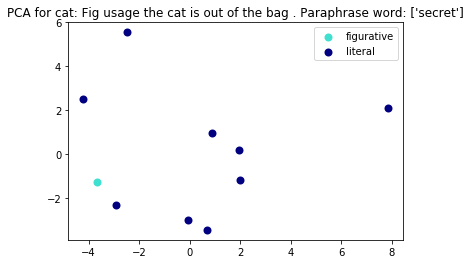

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


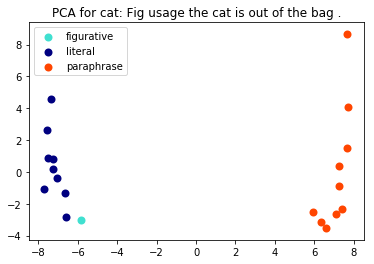

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


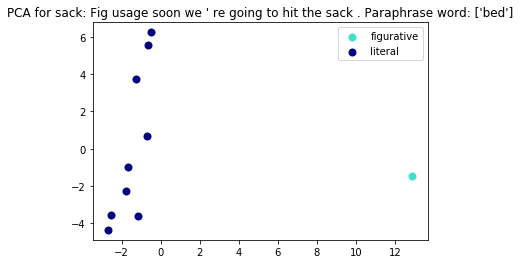

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


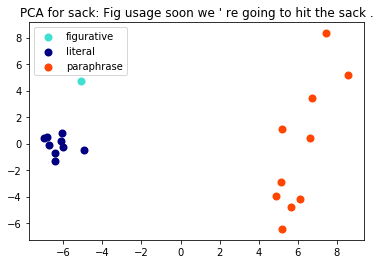

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


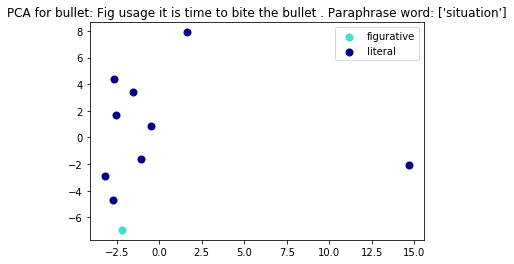

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


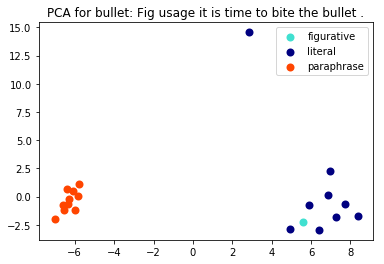

In [5]:
# BERT- BASE 

word_args = {
   'comparison_type': 'words',
    'input': 'word_vec_sim_test.txt',
    'embedding_model': 'bert-base-uncased',
    'run_name': 'word_base_test',
    'embedding_batch_size': 16,
    'embedding_cache': None
}

main(objectview(word_args))

In [6]:
# BERT - LARGE

sent_args = {
   'comparison_type': 'para_pairs',
    'input': '../probe/output/daniel/train_classifications.tsv',
    'embedding_model': 'bert-large-uncased',
    'run_name': 'paraphrase_large_test',
    'embedding_batch_size': 16,
    'embedding_cache': None
}

main(objectview(sent_args))

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-large-uncased-vocab.txt HTTP/1.1" 200 0
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt from cache at /Users/paigefink/.cache/torch/transformers/9b3c03a36e83b13d5ba95ac965c9f9074a99e14340c523ab405703179e79fc46.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:data_loading:Loading 'bert-large-uncased' model
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-large-uncased-config.json HTTP/1.1" 200 0
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-config.json from cache at /Users/paigefink/.cac

INFO:data_loading:processed 16/800 sentences, current max sentence length 64
INFO:data_loading:processed 32/800 sentences, current max sentence length 64
INFO:data_loading:processed 48/800 sentences, current max sentence length 112
INFO:data_loading:processed 64/800 sentences, current max sentence length 112
INFO:data_loading:processed 80/800 sentences, current max sentence length 112
INFO:data_loading:processed 96/800 sentences, current max sentence length 113
INFO:data_loading:processed 112/800 sentences, current max sentence length 113
INFO:data_loading:processed 128/800 sentences, current max sentence length 113
INFO:data_loading:processed 144/800 sentences, current max sentence length 113
INFO:data_loading:processed 160/800 sentences, current max sentence length 113
INFO:data_loading:processed 176/800 sentences, current max sentence length 113
INFO:data_loading:processed 192/800 sentences, current max sentence length 113
INFO:data_loading:processed 208/800 sentences, current max s

INFO:data_loading:Caching info for this run in cache/paraphrase_large_test
INFO:data_loading:Please pass this folder in to future invocations to use cached data
INFO:data_loading:Caching sentences.pt in cache/paraphrase_large_test
INFO:data_loading:Caching inputs.pt in cache/paraphrase_large_test
INFO:data_loading:Caching indices.pt in cache/paraphrase_large_test


[{'pair_index': 0, 'sent_1': '[CLS] i don\'t know if it\'s a " fetish, " necessarily, but he\'s ( i\'m gonna go out on a limb here and assume it\'s a " he " ) very disturbed [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', 'sent_2': '[CLS] i don\'t know if it\'s a " fetish, " necessarily, but he\'s ( i\'m gonna guess and assume it\'s a " he " ) very disturbed [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [ ]:
sent_args = {
   'comparison_type': 'para_pairs',
    'input': '../probe/output/daniel/train_classifications.tsv',
    'embedding_model': 'bert-large-uncased',
    'run_name': 'paraphrase_large_test',
    'embedding_batch_size': 16,
    'embedding_cache': 'cache/paraphrase_large_test'
}

main(objectview(sent_args))